# Molecular networking with DreaMS embeddings

## Introduction

DreaMS embeddings can be naturally used for molecular networking. Once the embeddings are computed, their similarity can be used to connect spectra into a k-nearest neighbor (k-NN) graph forming a molecular network. Our paper (https://www.nature.com/articles/s41587-025-02663-3) shows that DreaMS spectral similarity outperforms prior methods (e.g., modified cosine similarity, spectral entropy, MS2DeepScore) in terms of:
	•	Correlation to chemical similarity of underlying compounds
	•	Library matching performance (retrieval of different spectra of the same compound)
	•	Analog search performance (retrieval of spectra of distinct but structurally similar compounds)
	•	Robustness to low-quality spectra

Unlike traditional spectral similarity methods that primarily rely on direct matching of peaks and their intensities, DreaMS similarity is derived from a neural network–based approach. As a result, DreaMS often finds connections between spectra that may not be directly related according to conventional metrics, but are likely to represent structurally similar molecules. This ability to detect additional relationships makes DreaMS particularly powerful for molecular networking.

Before building a full network, we’ll first look at a few spectrum pairs where DreaMS sees a strong relationship but a traditional modified cosine score stays low.

In [1]:
import sys
from pathlib import Path

sys.path.append(str(Path().resolve().parent))
from paths import PROJECT_ROOT

import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity

import dreams.utils.spectra as su
from dreams.api import dreams_embeddings
from dreams.utils.data import MSData
from dreams.definitions import *
import math

/Users/macbook/UTILS/anaconda3/envs/dreams_mimb/lib/python3.11/site-packages/lightning_fabric/__init__.py:41: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
Determination of memory status is not supported on this 
 platform, measuring for memoryleaks will never fail


In [2]:
def suppress_rdkit() -> None:
    """Silence RDKit python logger if present."""
    try:
        from rdkit import RDLogger
        RDLogger.DisableLog('rdApp.*')
    except Exception:
        pass


### Here we will use again MassSpecGym reference library, for this we already process massspecgym in previous tutorial 3_library_matching.ipynb and for each spectra in library we computed DreaMS embedding, if not do not worry, we reapet process here again, but if it is already done, then we skip recomputation process

### And further we will use our processed data from 2_deduplication.ipynb

In [6]:
# 1a) Path to MassSpecGym spectral library (MGF and derived files)
mgf_path      = PROJECT_ROOT / "data" / "massspecgym" / "MassSpecGym.mgf"
lib_h5        = mgf_path.with_suffix(".hdf5")  # will be created automatically if not present
lib_emb_path  = lib_h5.with_name(lib_h5.stem + "_dreams_emb.npy")  # DreaMS embeddings

# 1b) Path to query spectra (your deduplicated and QC-filtered data from previous steps)
query_h5       = PROJECT_ROOT / "data" / "Piper_sirius_all_annotated_high_quality_dedup.hdf5"
query_emb_path = query_h5.with_name(query_h5.stem + "_dreams_emb.npy")

# 1c) Results folder (all output CSVs)
results_folder = PROJECT_ROOT / "results"
results_folder.mkdir(exist_ok=True)

**What these paths do:**

- `mgf_path`: Points to the downloaded **MassSpecGym** reference library (MGF format).
- `lib_h5`: The **HDF5** version of the library.
- `lib_emb_path`: Where the **pre-computed** (or to-be-computed) **DreaMS embeddings** for the library are saved.
- `query_h5`: The **deduplicated, high-quality spectra** from your own data (created in previous tutorials).
- `query_emb_path`: Where your **query spectra’s DreaMS embeddings** are (or will be) saved.
- `results_folder`: Where all **outputs** (e.g., top matches CSV) will be saved.

> **Tip:**  
> If you use different paths or file names, update the code above to match.

Load the MassSpecGym library

This step checks for an existing HDF5 copy of MassSpecGym and loads it instantly if present.
If not, it parses the .mgf and creates the .hdf5 for next time.

In [7]:
if lib_h5.exists():
    msdata_lib = MSData.from_hdf5(lib_h5, in_mem=True)
else:
    msdata_lib = MSData.load(
        mgf_path,
        in_mem=True,
        prec_mz_col="PRECURSOR_MZ"
    )

Loading dataset MassSpecGym into memory (231104 spectra)...


Compute (or load) DreaMS embeddings for the library

DreaMS turns each spectrum into a 1024-dimensional vector. Similar spectra live close together in this space, and we can compare them efficiently with cosine similarity.
	•	If *_dreams_emb.npy already exists, we load it immediately.
	•	Otherwise, we compute embeddings once and save them for reuse.

Tip
Computing embeddings can take a while the first time. Subsequent runs are instant because we reuse the saved .npy.

In [8]:
if lib_emb_path.exists():
    embs_lib = np.load(lib_emb_path)
    print("Loaded saved library embeddings:", embs_lib.shape)
else:
    embs_lib = dreams_embeddings(msdata_lib)
    np.save(lib_emb_path, embs_lib)
    print("Computed & saved library embeddings:", embs_lib.shape)

Loaded saved library embeddings: (231104, 1024)


### Loading your query spectra and computing DreaMS embeddings

For this tutorial, we use the **preprocessed, deduplicated, and high-quality spectra** prepared in **Tutorials 1 & 2**.

If you have not completed the preprocessing steps, you can use your own raw `.mgf` or `.mzML` file here — just create an `MSData` object as before:

In [9]:
if query_h5.exists():
    msdata_q = MSData.from_hdf5(query_h5, in_mem=True)
else:
    raise FileNotFoundError(f"Expected dedup HDF5 at {query_h5}")
print(f"Query loaded:   {len(msdata_q)} spectra → {query_h5.name}")

Loading dataset Piper_sirius_all_annotated_high_quality_dedup into memory (2799 spectra)...
Query loaded:   2799 spectra → Piper_sirius_all_annotated_high_quality_dedup.hdf5


In [10]:
if query_emb_path.exists():
    embs_q = np.load(query_emb_path)
    print("Loaded saved query embeddings:", embs_q.shape)
else:
    embs_q = dreams_embeddings(msdata_q)
    np.save(query_emb_path, embs_q)
    print("Computed & saved query embeddings:", embs_q.shape)

Loaded saved query embeddings: (2799, 1024)


Spot “extra” connections DreaMS can see

In classical molecular networking you decide whether to connect two spectra by applying a similarity threshold. Here we’ll:
	•	Compute the all-vs-all cosine similarity between query embeddings.
	•	Look at pairs with DreaMS similarity > 0.85 (very similar in the embedding space).
	•	For those pairs, also compute modified cosine on the raw spectra and filter out anything with modified cosine > 0.7.

Tip you can set threshold by yourself, changing the THLD_SAMPLE variable. Try 0.8 or 0.9 to see more/fewer examples.

What’s left are pairs that DreaMS thinks are strongly related but the traditional peak-matching score does not. These are exactly the kinds of links DreaMS contributes to molecular networking.


In [11]:
THLD_SAMPLE = 0.85 

In [12]:
sims = cosine_similarity(embs_q)
x, y = np.where(sims > THLD_SAMPLE)

# Define modified cosine similarity function
cos_sim = su.PeakListModifiedCosine(mz_tolerance=0.05)

2561 2775
DreaMS similarity: 0.8624699
Modified cosine similarity: 0.681061846480982


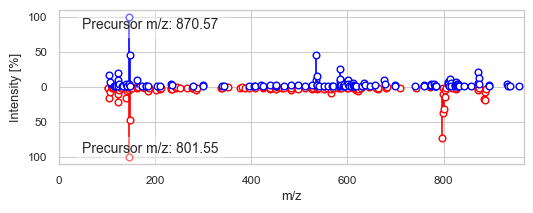

714 1268
DreaMS similarity: 0.8801018
Modified cosine similarity: 0.6845346968908029


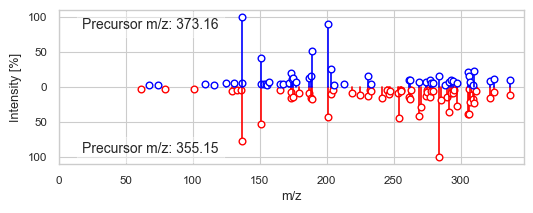

2502 2551
DreaMS similarity: 0.85027987
Modified cosine similarity: 0.27472129259511896


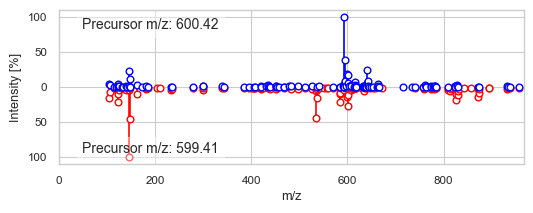

2579 2681
DreaMS similarity: 0.8748289
Modified cosine similarity: 0.48600127072507254


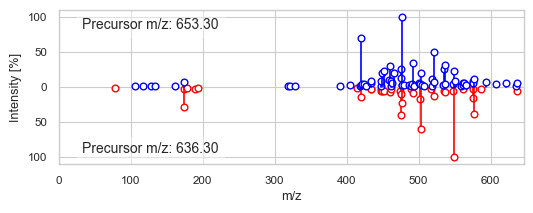

2645 2663
DreaMS similarity: 0.88989276
Modified cosine similarity: 0.47658023830008844


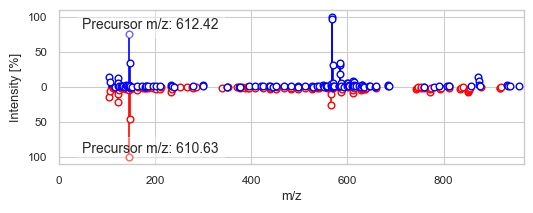

2389 2714
DreaMS similarity: 0.85268414
Modified cosine similarity: 0.48642973884004725


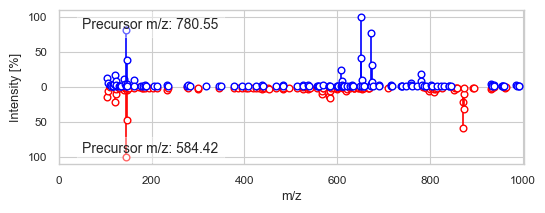

2250 2266
DreaMS similarity: 0.8527591
Modified cosine similarity: 0.5310888071882702


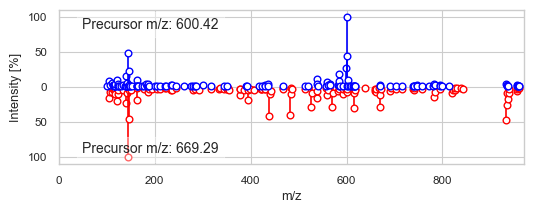

In [13]:
# Iterate over all pairs in random order and show 7 pairs
max_pairs, i_pairs = 7, 1
for i, (i1, i2) in enumerate(pd.Series(zip(x, y)).sample(frac=1, random_state=1)):

    # Do not show same pairs in different order twice
    if i1 > i2:
        continue

    # Skip spectra with less than 5 peaks
    if (msdata_q[SPECTRUM][i1][0] > 0).sum() < 5:
        continue

    # Compute modified cosine similarity
    spec1, spec2 = msdata_q[SPECTRUM][i1], msdata_q[SPECTRUM][i2]
    prec_mz1, prec_mz2 = msdata_q[PRECURSOR_MZ][i1], msdata_q[PRECURSOR_MZ][i2]
    cos_sim_i1_i2 = cos_sim(spec1=spec1, prec_mz1=prec_mz1, spec2=spec2, prec_mz2=prec_mz2)

    # Skip pairs with high modified cosine similarity
    if cos_sim_i1_i2 > 0.7:
        continue

    # Print information about the pair
    print(i1, i2)
    print('DreaMS similarity:', sims[i1, i2])
    print('Modified cosine similarity:', cos_sim_i1_i2)
    su.plot_spectrum(spec=spec1, prec_mz=prec_mz1, mirror_spec=spec2, mirror_prec_mz=prec_mz2)

    # Show max 7 pairs
    if i_pairs == max_pairs:
        break
    i_pairs += 1

## Molecular networking with DreaMS: three useful views of your data

DreaMS embeddings let us link MS/MS spectra by learned similarity rather than peak-by-peak matching. In this tutorial we build three versions of a network, each answering a slightly different question:
	1.	Query-only network (Q–Q)
“How do spectra within my sample relate to each other?”
We connect each query spectrum to its nearest neighbours within the sample using DreaMS similarity. No library data is used here.
	2.	Sample-centric network with library nodes (Q–Q + Q–L)
“Where do my spectra touch known chemistry?”
Starting from the query-only network, we pull in MassSpecGym nodes that are highly similar to at least one query spectrum. This adds library context (as extra nodes and Q–L edges) without drowning the graph in the entire library.
	3.	Annotation-only overlay (Q–Q + tags, no new nodes)
“Which of my spectra have a confident library hit?”
We do not add library nodes. Instead, each query node is tagged if its top-1 MassSpecGym match is strong enough, so you can color/filter nodes by “has library hit”.


Parameters at a glance

Keep these five numbers visible while you explore. They control density, strictness, and how much library signal you bring in.
	•	K_QUERY = 3
How many neighbours each query node tries to connect to inside your sample.
↑ Larger → denser network; ↓ smaller → sparser network.
	•	THLD_QUERY = 0.70
Minimum DreaMS similarity to keep a query↔query edge.
↑ Higher → stricter, fewer edges; ↓ lower → more edges.
	•	LIB_SIM_THLD = 0.80
Similarity cutoff for adding library nodes (used in the sample-centric network).
Only library spectra above this score are pulled in.
	•	LIB_TOPK_PER_Q = 5
Cap on how many library neighbors each query can bring in.
Helps prevent large hubs from exploding the graph.
	•	ASSIGN_THLD = 0.80
Top-1 assignment threshold for the annotation-only overlay.
A query is tagged as a “hit” only if its best library match ≥ this value.

Rule of thumb: Start conservative (e.g., K_QUERY=3, THLD_QUERY=0.7, LIB_SIM_THLD=0.8, ASSIGN_THLD=0.8).
If the network feels too fragmented, relax thresholds or increase K_QUERY.
If it’s too dense, do the opposite.

In [15]:
from benchmark.utils.data import (
    build_query_knn_graph, annotate_edges_modcos_qq,
    find_q2lib_neighbors, augment_with_library_nodes,
    tag_top1_assignment, export_graphs,
)

suppress_rdkit()

# Visible knobs:
K_QUERY = 3  # k in query-only kNN
THLD_QUERY = 0.70  # DreaMS similarity threshold for Q-Q edges
LIB_SIM_THLD = 0.80  # DreaMS similarity to pull in library nodes (task 2)
LIB_TOPK_PER_Q = 5  # cap library neighbors per query (task 2)
ASSIGN_THLD = 0.80  # DreaMS threshold for top-1 tag on queries (task 3)

1) Query-only network (Q–Q)

What you get
A clean view of relationships within your sample. Nodes are your spectra; edges link spectra that DreaMS considers similar enough.

What we actually do 
For each query spectrum, we look for its closest neighbours among the other queries. We keep only the strongest connections—those above THLD_QUERY—so the graph highlights meaningful structure.

Why this view matters
	•	Reveals chemical families present inside your data.
	•	Great first pass before involving any external knowledge.
	•	Small parameter surface: K_QUERY controls density; THLD_QUERY controls strictness.

Saved file
results/<sample>_network_QQ_k<K_QUERY>_t<int(THLD_QUERY*100)>.graphml
(e.g., ..._network_QQ_k3_t70.graphml)

In [16]:
# Build query-only graph
G1 = build_query_knn_graph(embs_q, k=K_QUERY, thld=THLD_QUERY)

# Edge metrics (rename weight->DreaMS_similarity + modified cosine)
annotate_edges_modcos_qq(G1, msdata_q, mz_tolerance=0.05)

# Also named export
export_graphs(G1, results_folder / f"{query_h5.stem}_network_QQ_k{K_QUERY}_t{int(THLD_QUERY * 100)}")

Saved GraphML → /Users/macbook/CODE/DreaMS_MIMB/results/Piper_sirius_all_annotated_high_quality_dedup_network_QQ_k3_t70.graphml


PosixPath('/Users/macbook/CODE/DreaMS_MIMB/results/Piper_sirius_all_annotated_high_quality_dedup_network_QQ_k3_t70.graphml')

2) Sample-centric network with library nodes (Q–Q + Q–L)

What you get
The same query-only backbone, plus selected MassSpecGym nodes that are very similar to at least one query spectrum. This gives you anchors to known chemistry without importing the whole library.

What we actually do (conceptually)
For each query spectrum, we search the library and keep the top hits above LIB_SIM_THLD (at most LIB_TOPK_PER_Q per query). Those library spectra are added as new nodes and connected to their query neighbors.

Why this view matters
	•	You see families in your sample and how they touch known molecules.
	•	Helpful for hypothesis generation and prioritization.
	•	Still sample-centric: only high-confidence library items appear.

Saved file
results/<sample>_network_QQlib_t<int(LIB_SIM_THLD*100)>.graphml
(e.g., ..._network_QQlib_t80.graphml)

Note: This network will have more nodes than your query-only graph (the added MassSpecGym hits). If it grows too big, raise LIB_SIM_THLD or lower LIB_TOPK_PER_Q.

In [17]:
G2 = G1.copy()

q2lib, lib_keep = find_q2lib_neighbors(
    embs_q, embs_lib, sim_thld=LIB_SIM_THLD, topk_per_q=LIB_TOPK_PER_Q
)

# with silence_everything():
augment_with_library_nodes(
    G2, q2lib, lib_keep,
    msdata_q=msdata_q, msdata_lib=msdata_lib,
    safe_lib_cols=None,  # no whitelist
    mz_tolerance=0.05,
)

export_graphs(G2, results_folder / f"{query_h5.stem}_sample_centric_lib{int(LIB_SIM_THLD * 100)}")
print(
    f"Augmented graph → nodes: {G2.number_of_nodes()} (queries={len(msdata_q)}, libs≈{len(lib_keep)}), edges: {G2.number_of_edges()}")

Saved GraphML → /Users/macbook/CODE/DreaMS_MIMB/results/Piper_sirius_all_annotated_high_quality_dedup_sample_centric_lib80.graphml
Augmented graph → nodes: 3076 (queries=2799, libs≈277), edges: 5894


3) Annotation-only overlay (Q–Q + tags, no new nodes)

What you get
Your original query-only network, but with per-node tags indicating whether a confident library match exists. No library nodes are added.

What we actually do
For each query, we find the best (top-1) library match. If its similarity is ≥ ASSIGN_THLD, we tag that query with:
	•	has_lib_hit = "hit"
	•	best_lib_similarity (numeric)
	•	best_lib_identifier (string)
	•	smiles (only if the node didn’t already have one; name kept as exactly smiles for ChemViz (https://www.rbvi.ucsf.edu/cytoscape/chemViz2/))

If the top-1 score is below the threshold, the node is tagged has_lib_hit = "no_hit".

Why this view matters
	•	Great when you want to stay inside your data but still highlight nodes with likely annotations.
	•	Works well with ChemViz (SMILES field is named smiles).


Saved file
results/<sample>_network_top1hit_th<int(ASSIGN_THLD*100)>.graphml
(e.g., ..._network_top1hit_th80.graphml)


In [18]:
G3 = G1.copy()
# with silence_everything():
tag_top1_assignment(
    G3,
    embs_q=embs_q, embs_lib=embs_lib, msdata_lib=msdata_lib,
    sim_thld=ASSIGN_THLD,
    overwrite_smiles=False,
)

export_graphs(G3, results_folder / f"{query_h5.stem}_network_top1hit_th{int(ASSIGN_THLD * 100)}")

hits = sum(1 for _, d in G3.nodes(data=True) if d.get("has_lib_hit") == "hit")
print(f"Top-1 MassSpecGym hits ≥ {ASSIGN_THLD}: {hits}/{G3.number_of_nodes()}")

Saved GraphML → /Users/macbook/CODE/DreaMS_MIMB/results/Piper_sirius_all_annotated_high_quality_dedup_network_top1hit_th80.graphml
Top-1 MassSpecGym hits ≥ 0.8: 273/2799


What you’ll see in Cytoscape (and how to color it)
	1.	Import → File → Import → Network from File… → the new .graphml (or .gexf).
	2.	Open Control Panel → Style (View → Control Panel if it’s hidden).
	3.	In Fill Color:
	•	Set Column = node_type → Discrete Mapping: color query (e.g., blue) and library (e.g., gold).